In [2]:
import torch
import torch.nn as nn
from pathlib import Path
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from math import *
import torch.distributions as tdist
from random import gauss,seed

In [3]:
import sys 
sys.path.insert(0,'/home/mohit/Downloads/code_notebooks/deep_boltzmann')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
from IPython.display import SVG

In [5]:
from deep_boltzmann.models import ParticleDimer
md = ParticleDimer()

Using TensorFlow backend.


In [6]:
#RNADE
class RNADE(nn.Module):
    def __init__(self,dimer_atoms,solvent_atoms):
        super(RNADE, self).__init__()
        self.dimer_atoms = dimer_atoms
        self.solvent_atoms = solvent_atoms
        self.total_dims = self.dimer_atoms + self.solvent_atoms
        self.i2h = nn.Linear(self.total_dims-1, self.total_dims-1)
        self.h2o = nn.Linear(self.total_dims-1, self.total_dims-self.dimer_atoms)
        self.D = self.total_dims
        self.H = 128
        self.params = nn.ParameterDict({
            "V" : nn.Parameter(torch.randn(self.D, self.H)),
            "b" : nn.Parameter(torch.zeros(self.D)),
            "V2" : nn.Parameter(torch.randn(self.D, self.H)),
            "b2" : nn.Parameter(torch.zeros(self.D)),
            "W" : nn.Parameter(torch.randn(self.H, self.D)),
            "c" : nn.Parameter(torch.zeros(1, self.H)),
        })
        nn.init.xavier_normal_(self.params["V"])
        nn.init.xavier_normal_(self.params["V2"])
        nn.init.xavier_normal_(self.params["W"])
        
    def forward(self, x):
        ai = self.params["c"].expand(x.size(0), -1)   #B x H
        a1=[]
        m1 = []
        for d in range(self.D):
            h_i = torch.relu(ai) #B x H
            alpha1 = torch.sigmoid( h_i.mm(self.params["V"][d:d+1,:].t() ) + self.params["b"][d:d+1] )*2  + pow(10,-1) + 0.5#  BxH *  Hx1  
            mean1 = h_i.mm(self.params["V2"][d:d+1,:].t() ) + self.params["b2"][d:d+1]
            a1.append(alpha1)
            m1.append(mean1)
            ai = x[:, d:d+1].mm(self.params["W"][:, d:d+1].t() ) + ai #Bx1 * 1xH =  BxH
        
        a1 = torch.cat(a1,1)
        m1 = torch.cat(m1,1)
        final_prob = torch.stack([m1,a1])       
     
        return final_prob

    def sample(self, x):
        ai = self.params["c"].expand(x.size(0), -1)
        means = []
        alphas = []
        boj = []
        sample = x
        for d in range(self.D):
            h_i = torch.relu(ai)
            if(d<4):
                ai = sample[:, d:d+1].mm(self.params["W"][:,d:d+1].t()) + ai
                continue
            alpha = torch.sigmoid( h_i.mm(self.params["V"][d:d+1,:].t() ) + self.params["b"][d:d+1] )*2  + pow(10,-1) + 0.5#  BxH *  Hx1  
            mean = h_i.mm(self.params["V2"][d:d+1,:].t() ) + self.params["b2"][d:d+1]
            means.append(mean)
            alphas.append(alpha)
            x1= mean
            boj.append(mean)
            ai = x1.mm(self.params["W"][:, d:d+1].t() ) + ai
        boj = torch.cat(boj,1)
        return boj

In [7]:
def lossFunct(output,pred,ind):
    alpha = output[1, :,4:]
    mean = output[0, :, 4:]
    loss = torch.exp( -0.5 *  ( (pred[:,4:]- mean)/alpha)**2  )/(alpha*sqrt(2*3.14) ) +pow(10,-10)
    print ( (loss == 0).nonzero() )
    print("Loss:")
    print(ind, -torch.log( loss ).sum(axis= 0)[ind]/alpha.size()[0] )
    return -torch.log( loss ).sum(axis= 0)[ind]/alpha.size()[0]

In [8]:
def otherLoss(output,pred):
    alpha = output[1, :,4:]
    mean = output[0, :, 4:]
    loss = torch.exp( -0.5 *  ( (pred[:,4:]- mean)/alpha)**2  )/(alpha*sqrt(2*3.14) ) +pow(10,-10)
    print("Loss:")
    return -torch.log( loss ).sum(axis= 0).sum()/alpha.size()[0]

In [9]:
def thresholdFunction(output, threshold):
    total = 0 
    for eachOutput in output:
        if(eachOutput>threshold):
            total += 1
    return total

In [10]:
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [39]:
PATH = "RNADEClosed2"
device = "cpu"

In [40]:
model = RNADE(4,72).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

RNADE(
  (i2h): Linear(in_features=75, out_features=75, bias=True)
  (h2o): Linear(in_features=75, out_features=72, bias=True)
  (params): ParameterDict(
      (V): Parameter containing: [torch.FloatTensor of size 76x128]
      (V2): Parameter containing: [torch.FloatTensor of size 76x128]
      (W): Parameter containing: [torch.FloatTensor of size 128x76]
      (b): Parameter containing: [torch.FloatTensor of size 76]
      (b2): Parameter containing: [torch.FloatTensor of size 76]
      (c): Parameter containing: [torch.FloatTensor of size 1x128]
  )
)

In [41]:
def trainModel(Model, trainLoader,optimizer, lossFunction, validate = False, epochs = 1, outputFile = None):
    for epoch in range(epochs):
        print(epoch)
        running_loss = 0.0
        for i, data in enumerate(trainLoader, 0):
                x_hat = model(data)
                loss = lossFunction(x_hat, data)
                if(not validate):
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                print(loss.item())
                running_loss += loss.item()
        if(outputFile):
            torch.save(Model.state_dict(), outputFile)
        print("Running Loss is " + str(running_loss) )
        
    return Model


In [42]:
def sampling(Model, loader):
    sampled = None
    t = None
    real = None
    for i, data in enumerate(loader, 0):
        if(t is not None):
            t = torch.cat((t,data[:,:4]),0)
        else:
            t = data[:,:4] 
        if(sampled is not None):
            sampled = torch.cat((sampled, Model.sample(data[:,:4]) ),0)
        else:
            sampled = Model.sample(data[:,:4])
        if(real is not None):
            real = torch.cat( (real, data), 0)
        else:
            real = data
    FullConfiguration = torch.cat((t,sampled), 1)
    return FullConfiguration, real

In [43]:
batch_size = 256
train_set = traj_closed_train[80000::10]

In [44]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [45]:
[PredictedConfig, RealConfig] = sampling(model,train_loader)

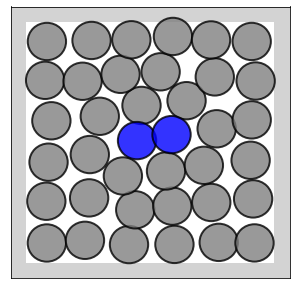

In [46]:
md.draw_config(PredictedConfig[5], dimercolor='blue', alpha=0.8)

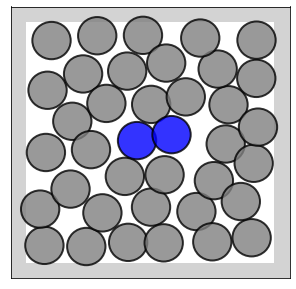

In [47]:
md.draw_config(np.array(RealConfig[5]), dimercolor='blue', alpha=0.8)

In [48]:
PredictedConfigEnergy = md.energy(np.array(PredictedConfig.detach()))

In [51]:
print ( thresholdFunction(PredictedConfigEnergy, 100.0) )

96


In [35]:
bins = [30,40,50,60,70,80,90,100,200]

(array([873., 659., 196.,  92.,  52.,  16.,  16.,  49.]),
 array([ 30,  40,  50,  60,  70,  80,  90, 100, 200]),
 <a list of 8 Patch objects>)

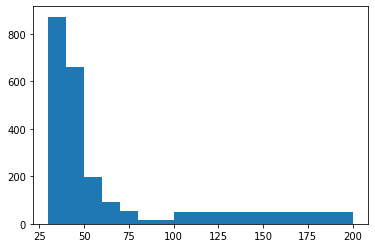

In [36]:
plt.hist(np.array(PredictedConfigEnergy),bins = bins)

In [37]:
energyMc = md.energy(np.array(RealConfig.detach()))
print ( thresholdFunction(energyMc, 100.0) )

0


(array([   0.,  226., 1294.,  433.,   47.,    0.,    0.]),
 array([ 30,  40,  50,  60,  70,  80,  90, 100]),
 <a list of 7 Patch objects>)

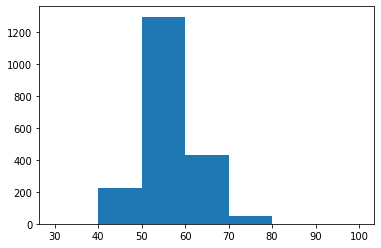

In [38]:
plt.hist(np.array(energyMc),bins = [30,40,50,60,70,80,90,100])